In [1]:
## %pylab inline
#start a timer
import time
start_time = time.time()

#import operating system 
from os import listdir
from os.path import isfile, join

#To Show Images
import numpy as np
import nibabel as nib
from nilearn import plotting
import pickle
import matplotlib.pyplot as plt
from jupyterplot import ProgressPlot

# Import Pytorch
import torch
import torchvision
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
#from torchsummary import summary

from custom_dataset import LabelsDataset

#Monai (Import data and transform data)
from monai.transforms import \
    Compose, AddChannel, ScaleIntensity, ToTensor, Resize, RandRotate, RandFlip, RandScaleIntensity, RandZoom, RandGaussianNoise, RandAffine, ResizeWithPadOrCrop

## Choose architecture
α-WGANSigmaRat1 => arch1

α-WGANSigmaRat2 => arch2

In [2]:
#architecture = "arch1"
architecture = "arch2"

In [3]:
# Import Generator, Discriminator, Encoder and Code Discriminator 
if architecture == "arch1":
    from WGAN_SigmaRat1 import *
if architecture == "arch2":
    from WGAN_SigmaRat2 import *

# Configuration -> Constants



In [4]:
#_______________________________________________Constants_______________________________________________
DEBUG = True
# PATH_DATASET = 'path/to/the/dataset/MRI/'

BEGINNING_TRAIN = True # always false, unless it is to train from the beginning
DEVICE = torch.device('cuda')

# Neural net
BATCH_SIZE = 16 # batch_size must be a divisor of the data set number.
WORKERS = 4
_EPS = 1e-15 #for calc_gradient_penalty
TOTAL_ITER = 3000

# Train_Weights
if architecture == "arch1":
    # loss1 = l1_loss*L1_WEIGHT - cd_z_hat_loss*CD_Z_HAT_WEIGHT - d_loss*D_WEIGHT+ mse_loss*MSE_WEIGHT
    L1_WEIGHT = 10
    CD_Z_HAT_WEIGHT = 1
    D_WEIGHT = 1
    MSE_WEIGHT = 10
    
    #----------------------
    # loss2 = x_loss2*X_LOSS2_WEIGHT + (gradient_penalty_r+gradient_penalty_h)*GP_D_WEIGHT
    X_LOSS2_WEIGHT = 1
    GP_D_WEIGHT = 10
    
    #----------------------
    # loss3 = x_loss3*X_LOSS3_WEIGHT + gradient_penalty_cd * GP_CD_WEIGHT
    X_LOSS3_WEIGHT = 1
    GP_CD_WEIGHT = 10

if architecture == "arch2":
    # loss1 = -cd_z_hat_loss*CD_Z_HAT_WEIGHT - d_loss*D_WEIGHT + mse_loss*MSE_WEIGHT + gd_loss*GD_WEIGHT
    CD_Z_HAT_WEIGHT = 1
    D_WEIGHT = 1
    MSE_WEIGHT = 100 
    GD_WEIGHT = 1/100
    
    #----------------------
    # loss2 = x_loss2*X_LOSS2_WEIGHT + (gradient_penalty_r+gradient_penalty_h)*GP_D_WEIGHT
    X_LOSS2_WEIGHT = 1
    GP_D_WEIGHT = 100
    
    #----------------------
    # loss3 = x_loss3*X_LOSS3_WEIGHT + gradient_penalty_cd * GP_CD_WEIGHT
    X_LOSS3_WEIGHT = 1
    GP_CD_WEIGHT = 100

#----------------------
# setting latent variable sizes
LATENT_DIM = 500

# Data Set Creator

In [5]:
# def create_train_dataset_list(path_dataset):
#     dataset = [f for f in listdir(path_dataset) if isfile(join(path_dataset, f))]
#     train_dataset=list()
#     for i in dataset:
#         train_dataset.append(path_dataset+i)
#     return train_dataset

# train_dataset = create_train_dataset_list(PATH_DATASET) #creat a list of paths

### Using Monai Transformation
* Resize (64x64x64)
* Rotate (3º)
* Flip (x axis)
* Rand Scale Intensity (±0.1)
* Zoom (1.1)
* Gaussian Noise (0.01)
* Scale Intensity Norm (-1,1)
* Translate (4x4x0)

In [6]:
def create_train_loader():
    # train_transforms = Compose([AddChannel(),
    #                             ResizeWithPadOrCrop(spatial_size =(64, 64, 64), mode='constant'),
    #                             RandRotate(prob=0.1, range_x=0.052, range_y =0.052, range_z =0.052),
    #                             RandFlip(prob=0.1, spatial_axis=0),
    #                             RandScaleIntensity(prob=0.1, factors=(0.1)),
    #                             RandZoom(prob=0.1, min_zoom=(1.0), max_zoom=(1.1), mode="nearest"),
    #                             RandGaussianNoise(prob=0.1, mean=0, std=0.01),
    #                             ScaleIntensity(minv=-1.0, maxv=1.0),
    #                             RandAffine(prob=0.1, translate_range=(4,4,0)),
    #                             ToTensor()])
    train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                           transforms.RandomVerticalFlip(p=0.3),
                                           transforms.RandomRotation(degrees=10),
                                           transforms.ToTensor()])  # these do not work, I should fix it!!!
    
    train_ds = LabelsDataset(data_dir="/home/alikhan.nurkamal/brats-project/large-dataset/")
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=WORKERS, pin_memory=torch.cuda.is_available())
    return train_ds, train_loader

train_ds, train_loader = create_train_loader()

In [7]:
for label in train_loader:
    print(label.shape)
    break

torch.Size([16, 1, 64, 64, 64])


# NORMALZIE

In [8]:
def rescale_array(arr: np.ndarray, minv: float = 0.0, maxv: float = 1.0): #monmai function adapted
    """
    Rescale the values of numpy array `arr` to be from `minv` to `maxv`.
    """

    mina = torch.min(arr)
    maxa = torch.max(arr)

    if mina == maxa:
        return arr * minv

    norm = (arr - mina) / (maxa - mina)  # normalize the array first
    return (norm * (maxv - minv)) + minv  # rescale by minv and maxv, which is the normalized array by default

# Networks 
----
### Nomenclature 
* G -> Generator
* CD -> Code Discriminator
* D -> Discriminator
* E -> Encoder

In [9]:
def nets():
    G = Generator(noise=LATENT_DIM)
    CD = Code_Discriminator(code_size=LATENT_DIM, num_units=4096)
    D = Discriminator(is_dis=True)
    
    # __TO_GPU___
    G.cuda()   #|
    CD.cuda()  #|
    D.cuda()   #|
    #__________#|
    
    
    if architecture == "arch1":
        E = Discriminator(out_class=LATENT_DIM, is_dis=False)
        E.cuda()
        #______________________OPTIMIZERS______________________
        g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
        d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
        e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
        cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

    if architecture == "arch2":
        E = Encoder(out_class=LATENT_DIM, is_dis=False)
        E.cuda()
        #______________________OPTIMIZERS______________________
        g_optimizer = optim.AdamW(G.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
        d_optimizer = optim.AdamW(D.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
        e_optimizer = optim.AdamW(E.parameters(), lr = 0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
        cd_optimizer = optim.AdamW(CD.parameters(), lr = 0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
    
    return (G, CD, D, E, g_optimizer, cd_optimizer, d_optimizer, e_optimizer)

In [10]:
G, CD, D, E, g_optimizer, cd_optimizer, d_optimizer, e_optimizer = nets()

if DEBUG:
    print("----------------------------------------------------Networks----------------------------------------------------")
    print("--------------------------Generator--------------------------")
    print(G)
    print("--------------------------Discriminator--------------------------")
    print(D)
    print("--------------------------Encoder--------------------------")
    print(E)
    print("--------------------------Code-Discriminator--------------------------")
    print(CD)

----------------------------------------------------Networks----------------------------------------------------
--------------------------Generator--------------------------
Generator(
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (tp_conv1): ConvTranspose3d(500, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
  (bn1): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (tp_conv2): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn2): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (tp_conv3): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (tp_conv4): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn4): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_

# Gradient Penalty and Gradient Difference Loss

In [11]:
#___________________________________________WGAN-GP gradient penalty___________________________________________

#calc_gradient_penalty(model, real_data, generated_data)
def calc_gradient_penalty(model, x, x_gen):
    assert x.size() == x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_()
    x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat.requires_grad_(True)

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_EPS).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2

    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

In [12]:
'''
https://github.com/Y-P-Zhang/3D-GANs-pytorch/blob/master/models/losses.py
'''

#_____________________Gradient difference loss function_____________________
# def gdloss(real,fake):
#     dx_real = real[:, :, :, 1:, :] - real[:, :, :, :-1, :] 
#     dy_real = real[:, :, 1:, :, :] - real[:, :, :-1, :, :]
#     dz_real = real[:, :, :, :, 1:] - real[:, :, :, :, :-1]
#     dx_fake = fake[:, :, :, 1:, :] - fake[:, :, :, :-1, :]
#     dy_fake = fake[:, :, 1:, :, :] - fake[:, :, :-1, :, :]
#     dz_fake = fake[:, :, :, :, 1:] - fake[:, :, :, :, :-1]
#     gd_loss = torch.sum(torch.pow(torch.abs(dx_real) - torch.abs(dx_fake),2),dim=(2,3,4)) + \
#               torch.sum(torch.pow(torch.abs(dy_real) - torch.abs(dy_fake),2),dim=(2,3,4)) + \
#               torch.sum(torch.pow(torch.abs(dz_real) - torch.abs(dz_fake),2),dim=(2,3,4))
#     # torch.pow(value,2)==(value)**
    
#     return torch.sum(gd_loss)

def gdloss(real,fake):
    dreal = real[:, :, 1:, 1:, 1:] - real[:, :, :-1, :-1, :-1] #[BCHWD]
    dfake = fake[:, :, 1:, 1:, 1:] - fake[:, :, :-1, :-1, :-1]
    gd_loss = torch.sum((torch.abs(dreal) - torch.abs(dfake))**2, dim=(0, 1, 2, 3, 4))

    return gd_loss

# Training

In [13]:
def networks_params(D, Dtruth, CD, CDtruth, E, Etruth, G, Gtruth):
    for p in D.parameters():  
        p.requires_grad = Dtruth
    for p in CD.parameters():  
        p.requires_grad = CDtruth
    for p in E.parameters():  
        p.requires_grad = Etruth
    for p in G.parameters():  
        p.requires_grad = Gtruth
        
    return(D, CD, E, G)

In [14]:
if architecture == "arch1":
    criterion_l1 = nn.L1Loss()
    criterion_mse = nn.MSELoss()

    Lloss1 = list()
    Lloss2 = list()
    Lloss3 = list()
    L1LossL = list()
    MSELossL = list()
    
if architecture == "arch2":
    criterion_mse = nn.MSELoss()

    Lloss1 = list()
    Lloss2 = list()
    Lloss3 = list()
    MSELossL = list()
    Gd_LossL = list()

In [15]:
def see_information(iteration,loss2,loss1,loss3,l1_loss,mse_loss):
    #Save losses in lists
    Lloss1.append(float(loss1.data.cpu().numpy()))
    Lloss2.append(float(loss2.data.cpu().numpy()))
    Lloss3.append(float(loss3.data.cpu().numpy()))
    L1LossL.append(float(l1_loss.data.cpu().numpy()))
    MSELossL.append(float(mse_loss.data.cpu().numpy()))
    
    print('[{}/{}]'.format(iteration,TOTAL_ITER),
                  f'D: {loss2.data.cpu().numpy():<8.3}', 
                  f'En_Ge: {loss1.data.cpu().numpy():<8.3}',
                  f'Code: {loss3.data.cpu().numpy():<8.3}',
                  f'L1_Loss: {l1_loss.data.cpu().numpy():<8.3}',
                  f'MSE_Loss: {mse_loss.data.cpu().numpy():<8.3}',
                  )
    return(Lloss1, Lloss2, Lloss3, L1LossL, MSELossL)

def see_information2(iteration,loss2,loss1,loss3,mse_loss,gd_loss):
    #Save losses in lists
    Lloss1.append(float(loss1.data.cpu().numpy()))
    Lloss2.append(float(loss2.data.cpu().numpy()))
    Lloss3.append(float(loss3.data.cpu().numpy()))
    MSELossL.append(float(mse_loss.data.cpu().numpy()))
    Gd_LossL.append(float(gd_loss))
    
    print('[{}/{}]'.format(iteration,TOTAL_ITER),
                  f'D: {loss2.data.cpu().numpy():<8.3}', 
                  f'En_Ge: {loss1.data.cpu().numpy():<8.3}',
                  f'Code: {loss3.data.cpu().numpy():<8.3}',
                  f'MSE_Loss: {mse_loss.data.cpu().numpy():<8.3}',
                  f'Gd_Loss: {gd_loss:<8.3}',
                  )
    
    return(Lloss1, Lloss2, Lloss3, MSELossL, Gd_LossL)

In [16]:
def visualization(image, reality):
    feat = np.squeeze((0.5*image[0]+0.5).data.cpu().numpy())
    feat = nib.Nifti1Image(feat, affine=np.eye(4))
    plotting.plot_img(feat, title=reality)
    plotting.show()
    # print(torch.max(image[0]))
    # print(torch.min(image[0]))

In [17]:
def load_dict(start):
    G.load_state_dict(torch.load('./checkpoint/G_iter'+str(start)+'.pth'))
    CD.load_state_dict(torch.load('./checkpoint/CD_iter'+str(start)+'.pth'))
    E.load_state_dict(torch.load('./checkpoint/E_iter'+str(start)+'.pth'))
    D.load_state_dict(torch.load('./checkpoint/D_iter'+str(start)+'.pth'))
    
    g_optimizer = optim.AdamW(G.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
    d_optimizer = optim.AdamW(D.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
    e_optimizer = optim.AdamW(E.parameters(), lr = 0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
    cd_optimizer = optim.AdamW(CD.parameters(), lr = 0.0002, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
    
    # usar ADAMW
    return(G, CD, D, E, g_optimizer, cd_optimizer, d_optimizer, e_optimizer)

In [18]:
def training(resume, start):
    
    pp = ProgressPlot(plot_names=["Generator-Encoder", "Discriminator","Code-Discriminator", "Discriminator-Capacity"],
                 line_names=["Loss"])
    g_iter = 1
    d_iter = 1
    cd_iter =1
    if resume:
        G, CD, D, E, g_optimizer, cd_optimizer, d_optimizer, e_optimizer = load_dict(start)
    else:
        G, CD, D, E, g_optimizer, cd_optimizer, d_optimizer, e_optimizer = nets()
    
    print('Starting training...')
    for iteration in range(start, TOTAL_ITER):

        ###############################################
        # Train Encoder - Generator 
        ###############################################
        D, CD, E, G = networks_params(D=D, Dtruth=False, CD=CD, CDtruth=False, E=E, Etruth=True, G=G, Gtruth=True)
        
        for iters in range(g_iter):
            G.zero_grad()
            E.zero_grad()
            real_images = next(iter(train_loader)) #next image
            _batch_size = real_images.size(0)
            
            real_images = real_images.to(DEVICE) #next image into de GPU
            z_rand = torch.randn((_batch_size, LATENT_DIM)).to(DEVICE) #random vector
            z_hat = E(real_images).view(_batch_size, -1) #Output vector of the Encoder
            x_hat = G(z_hat) #Generation of an image using the encoder's output vector
            x_rand = G(z_rand) #Generation of an image using a random vector
            
            #Code discriminator absolute value of the encoder's output vector 
            cd_z_hat_loss = CD(z_hat).mean() #(considering the random vector as real) 
            
            #calculation of the discriminator loss
            d_real_loss = D(x_hat).mean() #of the output vector of the Encoder
            d_fake_loss = D(x_rand).mean() #of the random vector
            d_loss = d_fake_loss+d_real_loss
            
            if architecture == "arch1":
                #_____________MSE_loss_____________
                mse_loss = criterion_mse(x_hat,real_images) 
                #_____________L1_Loss_____________
                l1_loss = criterion_l1(x_hat,real_images)

                #__________Generator_Loss__________
                loss1 = l1_loss*L1_WEIGHT - cd_z_hat_loss*CD_Z_HAT_WEIGHT - d_loss*D_WEIGHT+ mse_loss*MSE_WEIGHT

            
            if architecture == "arch2":
                #_____________Mean_Squared_Error_____________
                mse_loss = criterion_mse(x_hat,real_images) 

                #_____________Gradient_Different_Loss_____________
                gd_loss = gdloss(real_images,x_hat).item() #considering axis -> x,y,z

                #__________Generator_Loss__________

                # this loss function is based on this
                loss1 = -cd_z_hat_loss*CD_Z_HAT_WEIGHT - d_loss*D_WEIGHT + mse_loss*MSE_WEIGHT + gd_loss*GD_WEIGHT #correct

            if iters < g_iter-1:
                loss1.backward()
            else:
                loss1.backward(retain_graph=True)
            e_optimizer.step()
            g_optimizer.step()
            g_optimizer.step()

        ###############################################
        # Train Discriminator
        ###############################################
        D, CD, E, G = networks_params(D=D, Dtruth=True, CD=CD, CDtruth=False, E=E, Etruth=False, G=G, Gtruth=False)
        
        for iters in range(d_iter):
            d_optimizer.zero_grad()
            real_images = next(iter(train_loader)) #next image
            _batch_size = real_images.size(0)
             
            z_rand = torch.randn((_batch_size,LATENT_DIM)).to(DEVICE) #random vector
            real_images = real_images.to(DEVICE) #next image into de GPU
            z_hat = E(real_images).view(_batch_size,-1) #Output vector of the Encoder
            x_hat = G(z_hat) #Generation of an image using the encoder's output vector
            x_rand = G(z_rand) #Generation of an image using a random vector
            
            #calculation of the discriminator loss (if it can distinguish between real and fake)
            x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean() 
            
            #calculation of the gradient penalty
            gradient_penalty_r = calc_gradient_penalty(D,real_images.data, x_rand.data)
            gradient_penalty_h = calc_gradient_penalty(D,real_images.data, x_hat.data)
            
            #__________Discriminator_loss__________
            loss2 = x_loss2*X_LOSS2_WEIGHT + (gradient_penalty_r+gradient_penalty_h)*GP_D_WEIGHT
            loss2.backward(retain_graph=True)
            d_optimizer.step()

        ###############################################
        # Train Code Discriminator
        ###############################################
        D, CD, E, G = networks_params(D=D, Dtruth=False, CD=CD, CDtruth=True, E=E, Etruth=False, G=G, Gtruth=False)    
        
        for iters in range(cd_iter):
            cd_optimizer.zero_grad()
            #random vector (considered as real here)
            z_rand = torch.randn((_batch_size,LATENT_DIM)).to(DEVICE)
            #Gradient Penalty between randon vector and encoder's output vector
            gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.data, z_rand.data) 
            
            x_loss3=-CD(z_rand).mean() + CD(z_hat).mean()
            
            #___________Code_Discriminator_Loss___________
            loss3 = x_loss3*X_LOSS3_WEIGHT + gradient_penalty_cd * GP_CD_WEIGHT
            loss3.backward(retain_graph=True)
            cd_optimizer.step()

        ###############################################
        # Visualization
        ###############################################
        if iteration % 100 == 0:
            pp.update([[float(loss1.data.cpu().numpy())],
                       [float(loss2.data.cpu().numpy())],
                       [float(loss3.data.cpu().numpy())],
                       [float(d_fake_loss.data.cpu().numpy())]])

            
            #Save losses in lists and print instant loss values
            if architecture == "arch1":
                Lloss1, Lloss2, Lloss3, L1LossL, MSELossL = see_information(iteration, loss2, loss1, loss3, l1_loss, mse_loss)
            
            if architecture == "arch2":
                Lloss1, Lloss2, Lloss3, MSELossL, Gd_LossL = see_information2(iteration, loss2, loss1, loss3, mse_loss, gd_loss)
            
            #Show the real image
            visualization(real_images, "Real")
            
            #Show the generated image using encoder's output vector
            visualization(x_hat, "x_hat")
            
            #Show the generated image using a random vector
            visualization(x_rand, "x_rand")
        
        ###############################################
        # Model Save
        ###############################################
        if (iteration + 1) % 100 == 0:
            torch.save(G.state_dict(), './checkpoint/G_iter'+str(iteration+1)+'.pth')
            torch.save(D.state_dict(), './checkpoint/D_iter'+str(iteration+1)+'.pth')
            torch.save(E.state_dict(), './checkpoint/E_iter'+str(iteration+1)+'.pth')
            torch.save(CD.state_dict(), './checkpoint/CD_iter'+str(iteration+1)+'.pth')
        
        resume = True

<IPython.core.display.Javascript object>

Starting training...
[1900/3000] D: 38.8     En_Ge: 4.62e+03 Code: 65.4     MSE_Loss: 1.37     Gd_Loss: 4.96e+05


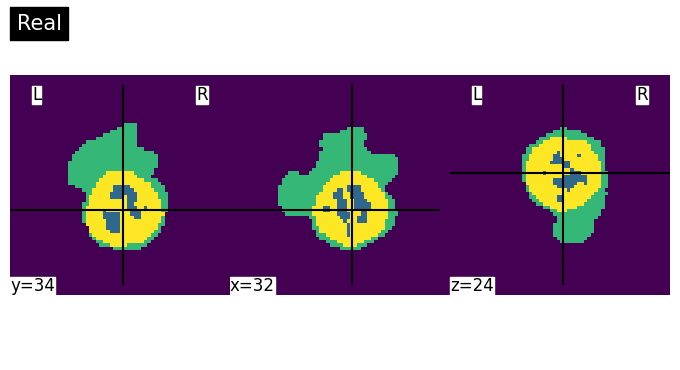

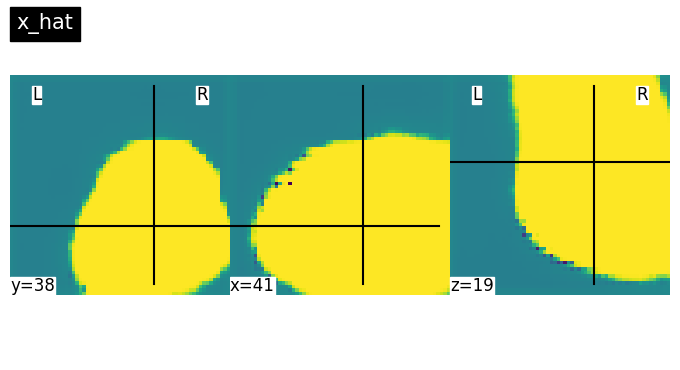

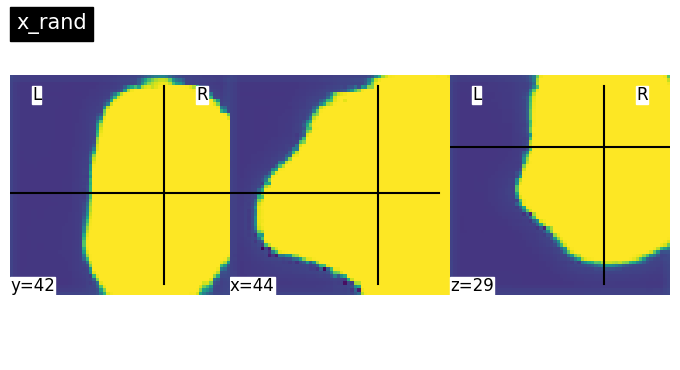

[2000/3000] D: 35.3     En_Ge: 4.35e+03 Code: 1.03e+02 MSE_Loss: 0.489    Gd_Loss: 5.35e+05


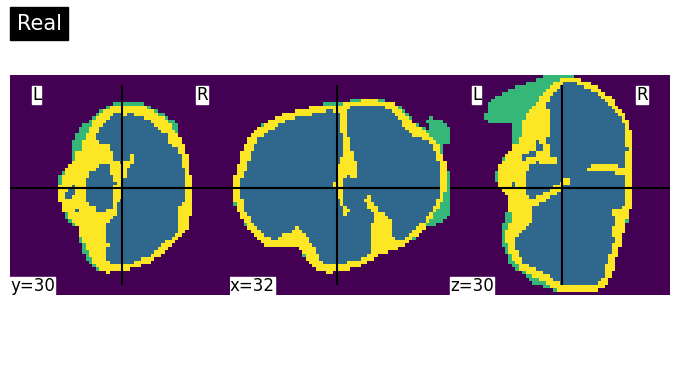

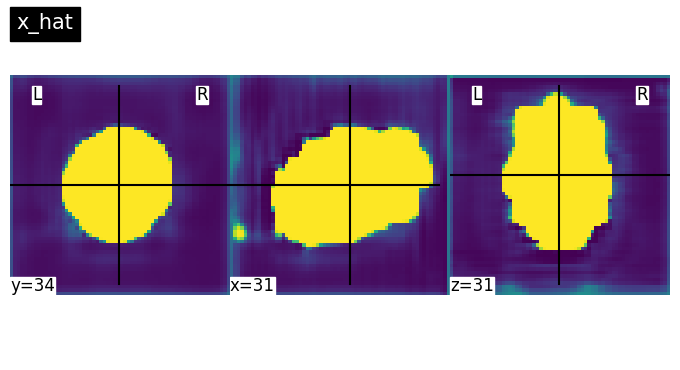

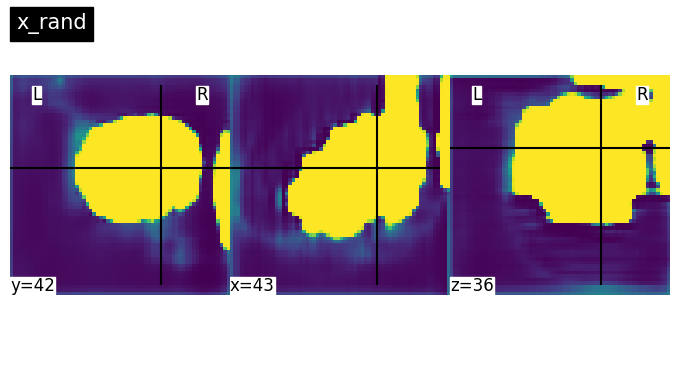

[2100/3000] D: -99.6    En_Ge: 6.4e+03  Code: 3.62     MSE_Loss: 0.529    Gd_Loss: 6.77e+05


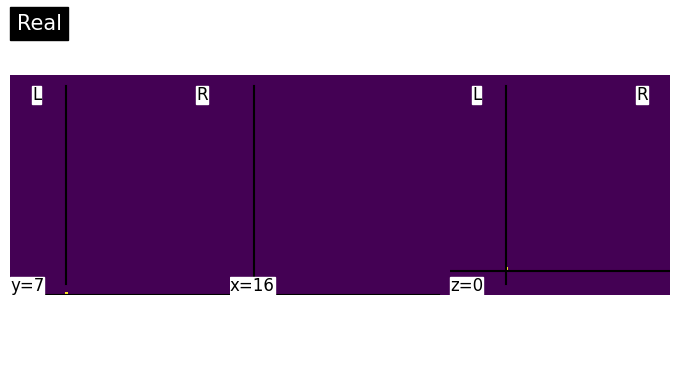

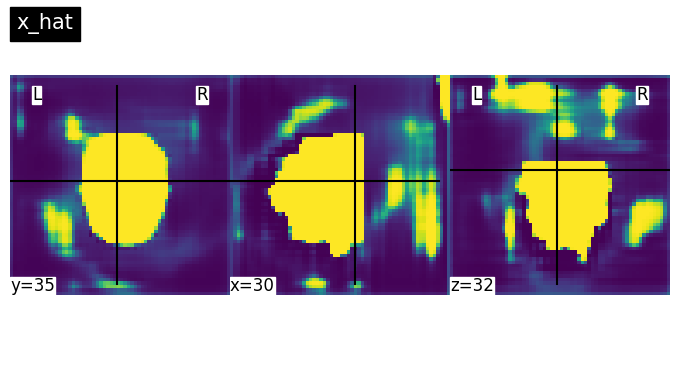

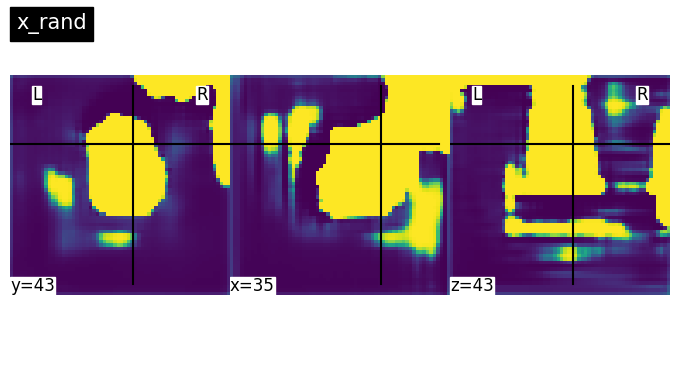

KeyboardInterrupt: 

In [19]:
training(resume=True, start=1900)
# pp.finalize()